# Perbandingan Logistic Regression vs Random Forest untuk Prediksi Diabetes

Notebook ini mengikuti rancangan studi kasus pada proposal:
- Dataset: **Diabetes Prediction Dataset (Kaggle)** (target biner `diabetes` 0/1).
- Pra-pemrosesan: pembersihan data, **encoding fitur kategorikal**, **scaling fitur numerik untuk Logistic Regression**, dan **stratified train-test split**.
- Penanganan ketidakseimbangan kelas: `class_weight` dan (opsional) resampling **SMOTE**.
- Evaluasi: **F1-score**, **ROC-AUC**, **confusion matrix**.
- Interpretasi: koefisien Logistic Regression, feature importance Random Forest, dan (opsional) **SHAP**.

> Catatan: agar runnable, simpan file CSV Kaggle di: `../data/diabetes_prediction_dataset.csv` (relative terhadap folder notebook).


## 1) Setup & Import Library

In [17]:
# Jika menjalankan di environment baru, pastikan dependensi dasar terpasang:
# pip install -U pandas numpy scikit-learn matplotlib joblib

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    f1_score, roc_auc_score, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay
)

import joblib

RANDOM_STATE = 42
TEST_SIZE = 0.2


## 2) Load Dataset

In [18]:
# Path default sesuai struktur project ini:
DATA_PATH = os.path.join("diabetes_prediction_dataset.csv")

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Dataset tidak ditemukan di {DATA_PATH}.\n"
        "Silakan download dari Kaggle dan simpan ke folder data/ dengan nama diabetes_prediction_dataset.csv"
    )

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())


Shape: (100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## 3) Data Quality Check (Missing, Duplicate, Tipe Data)

In [19]:
display(df.info())
display(df.describe(include="all").T)

print("\nMissing values per kolom:")
display(df.isna().sum())

dup = df.duplicated().sum()
print(f"Duplikat baris: {dup}")
if dup > 0:
    df = df.drop_duplicates()
    print("Shape setelah drop duplicates:", df.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,100000,3,Female,58552,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,100000.0,NaN,NaN,NaN,41.885856,22.51684,0.08,24.0,43.0,60.0,80.0
hypertension,100000.0,NaN,NaN,NaN,0.07485,0.26315,0.0,0.0,0.0,0.0,1.0
heart_disease,100000.0,NaN,NaN,NaN,0.03942,0.194593,0.0,0.0,0.0,0.0,1.0
smoking_history,100000,6,No Info,35816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,100000.0,NaN,NaN,NaN,27.320767,6.636783,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,NaN,NaN,NaN,5.527507,1.070672,3.5,4.8,5.8,6.2,9.0
blood_glucose_level,100000.0,NaN,NaN,NaN,138.05806,40.708136,80.0,100.0,140.0,159.0,300.0
diabetes,100000.0,NaN,NaN,NaN,0.085,0.278883,0.0,0.0,0.0,0.0,1.0



Missing values per kolom:


gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Duplikat baris: 3854
Shape setelah drop duplicates: (96146, 9)


## 4) EDA Singkat (Distribusi Target)

diabetes
0    87664
1     8482
Name: count, dtype: int64
Proporsi diabetes=1: 0.0882


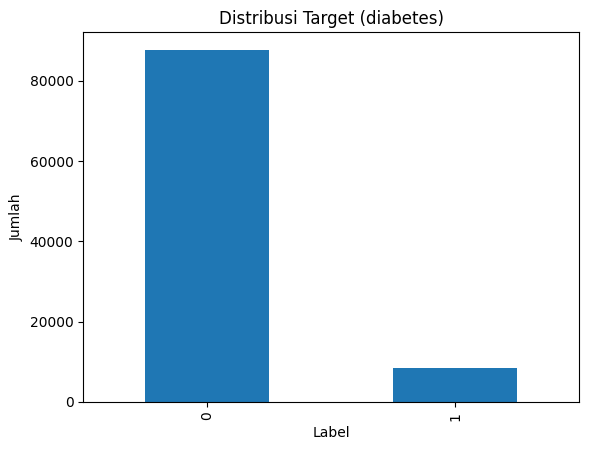

In [20]:
target_col = "diabetes"
if target_col not in df.columns:
    raise KeyError(f"Kolom target '{target_col}' tidak ditemukan. Kolom tersedia: {list(df.columns)}")

class_counts = df[target_col].value_counts().sort_index()
print(class_counts)

pos_rate = class_counts.get(1, 0) / class_counts.sum()
print(f"Proporsi diabetes=1: {pos_rate:.4f}")

ax = class_counts.plot(kind="bar")
ax.set_title("Distribusi Target (diabetes)")
ax.set_xlabel("Label")
ax.set_ylabel("Jumlah")
plt.show()


## 5) Split Data (Stratified Train-Test Split)

In [21]:
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train positive rate:", y_train.mean(), "Test positive rate:", y_test.mean())


Train: (76916, 8) Test: (19230, 8)
Train positive rate: 0.08822611680274585 Test positive rate: 0.08819552782111284


## 6) Preprocessing (Categorical Encoding + Scaling untuk LR)

In [22]:
# Identifikasi kolom kategorikal & numerik otomatis
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

# Pipeline preprocessing:
numeric_transformer_lr = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

numeric_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_lr = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_lr, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)

preprocess_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)


Categorical: ['gender', 'smoking_history']
Numeric: ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']


## 7) Helper Evaluasi

In [23]:
def evaluate_model(model, X_test, y_test, title="Model"):
    # Probabilitas kelas positif (diabetes=1)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    print(f"=== {title} ===")
    print(f"F1-score (positive class): {f1:.4f}")
    print(f"ROC-AUC: {roc:.4f}\n")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve - {title}")
    plt.show()

    return {"f1": f1, "roc_auc": roc}


## 8) Model 1 — Logistic Regression (Baseline)

=== Logistic Regression (class_weight=balanced) ===
F1-score (positive class): 0.5734
ROC-AUC: 0.9601

              precision    recall  f1-score   support

           0     0.9870    0.8850    0.9332     17534
           1     0.4253    0.8797    0.5734      1696

    accuracy                         0.8846     19230
   macro avg     0.7062    0.8824    0.7533     19230
weighted avg     0.9375    0.8846    0.9015     19230



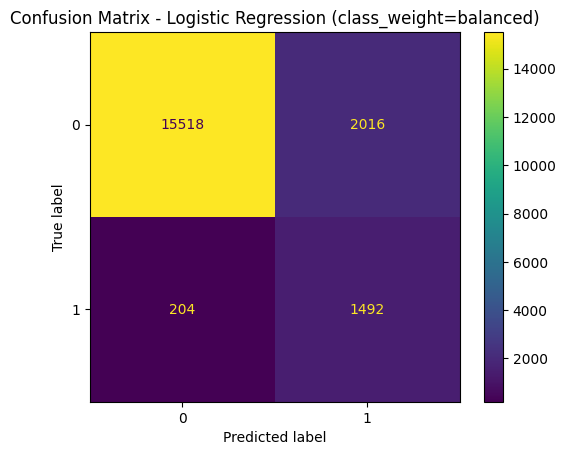

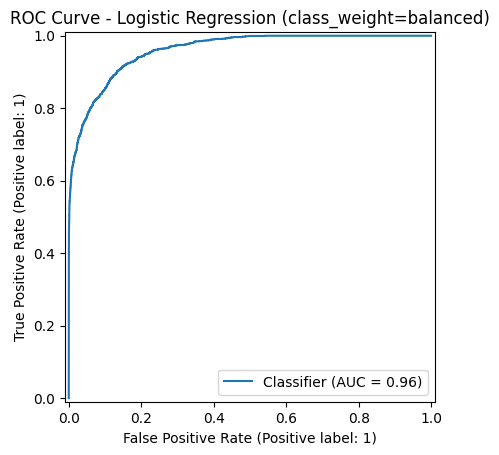

{'f1': 0.5734050730207533, 'roc_auc': 0.9600715106606894}

In [24]:
lr_clf = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    solver="saga",
    n_jobs=-1
)

pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess_lr),
    ("model", lr_clf)
])

pipe_lr.fit(X_train, y_train)
metrics_lr = evaluate_model(pipe_lr, X_test, y_test, title="Logistic Regression (class_weight=balanced)")
metrics_lr


## 9) Model 2 — Random Forest (Model Lanjutan)

=== Random Forest (Optimized & Deployment Ready) ===
F1-score (positive class): 0.6283
ROC-AUC: 0.9734

              precision    recall  f1-score   support

           0     0.9886    0.9085    0.9468     17534
           1     0.4851    0.8915    0.6283      1696

    accuracy                         0.9070     19230
   macro avg     0.7368    0.9000    0.7876     19230
weighted avg     0.9442    0.9070    0.9187     19230



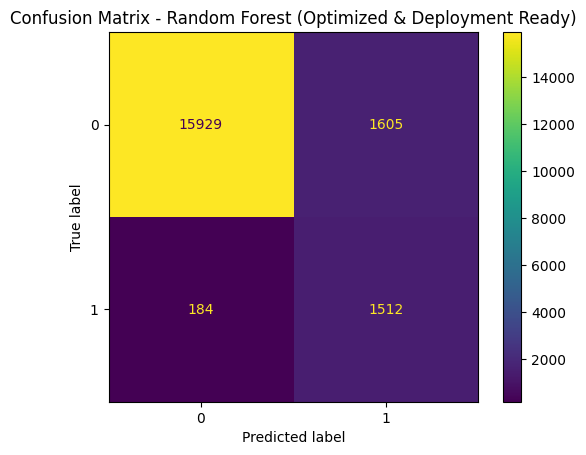

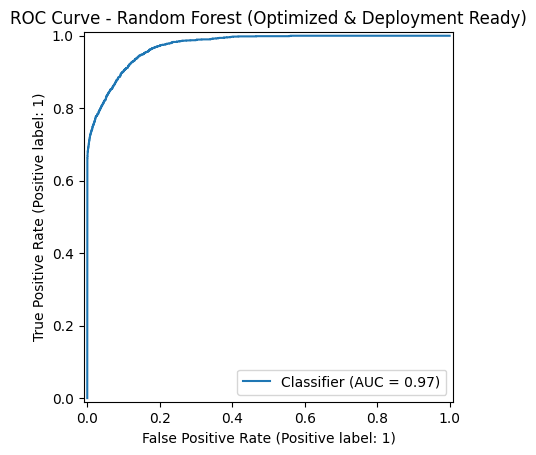

{'f1': 0.6282983586120923, 'roc_auc': 0.9733845940286365}

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_clf = RandomForestClassifier(
    n_estimators=120,          # 🔽 dari 300 → jauh lebih kecil
    max_depth=10,              # 🔽 batasi kedalaman tree
    min_samples_leaf=5,        # 🔽 kurangi kompleksitas
    max_features="sqrt",       # standar RF, lebih ringan
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess_rf),
    ("model", rf_clf)
])

pipe_rf.fit(X_train, y_train)

metrics_rf = evaluate_model(
    pipe_rf,
    X_test,
    y_test,
    title="Random Forest (Optimized & Deployment Ready)"
)

metrics_rf



## 10) Opsional — Resampling (SMOTE)

In [26]:
# SMOTE membutuhkan imbalanced-learn:
# pip install -U imbalanced-learn
# Sel ini akan otomatis skip jika library belum tersedia.

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline

    smote = SMOTE(random_state=RANDOM_STATE)

    pipe_lr_smote = ImbPipeline(steps=[
        ("preprocess", preprocess_lr),
        ("smote", smote),
        ("model", lr_clf)
    ])

    pipe_rf_smote = ImbPipeline(steps=[
        ("preprocess", preprocess_rf),
        ("smote", smote),
        ("model", rf_clf)
    ])

    pipe_lr_smote.fit(X_train, y_train)
    m_lr_smote = evaluate_model(pipe_lr_smote, X_test, y_test, title="LogReg + SMOTE")

    pipe_rf_smote.fit(X_train, y_train)
    m_rf_smote = evaluate_model(pipe_rf_smote, X_test, y_test, title="RF + SMOTE")

    print("Ringkasan (F1, ROC-AUC):")
    display(pd.DataFrame([
        {"model":"LogReg (class_weight)", **metrics_lr},
        {"model":"RF (class_weight)", **metrics_rf},
        {"model":"LogReg + SMOTE", **m_lr_smote},
        {"model":"RF + SMOTE", **m_rf_smote},
    ]))

except ImportError as e:
    print("imbalanced-learn belum terpasang. Lewati SMOTE.\n", str(e))


imbalanced-learn belum terpasang. Lewati SMOTE.
 No module named 'imblearn'


## 11) Interpretabilitas

### 11.1 Koefisien Logistic Regression (Top fitur)

,feature,coef
4,num__HbA1c_level,2.304505
5,num__blood_glucose_level,1.289632
0,num__age,1.147169
3,num__bmi,0.633895
8,cat__gender_Other,-0.526289
9,cat__smoking_history_No Info,-0.450221
7,cat__gender_Male,0.397767
1,num__hypertension,0.208219
2,num__heart_disease,0.153698
10,cat__smoking_history_current,0.134283


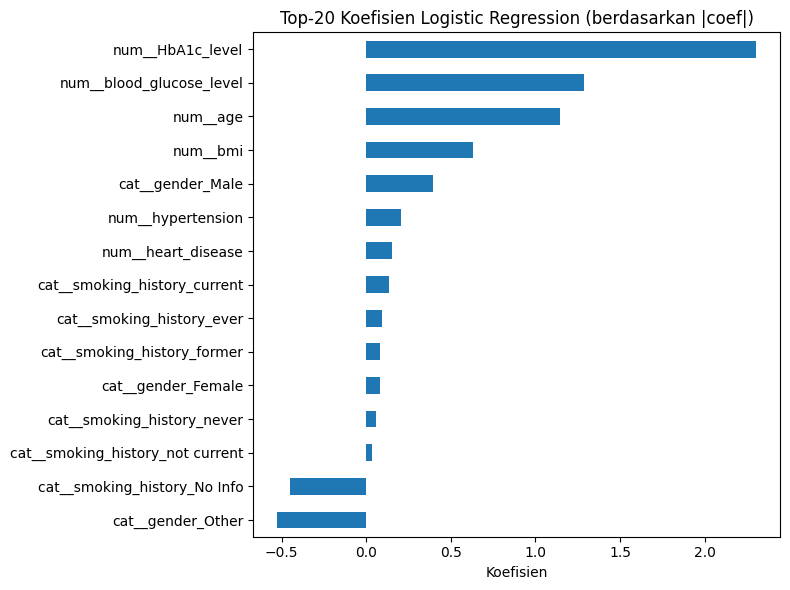

In [27]:
# Ambil nama fitur setelah one-hot
feature_names_lr = pipe_lr.named_steps["preprocess"].get_feature_names_out()
coefs = pipe_lr.named_steps["model"].coef_.ravel()

coef_df = pd.DataFrame({"feature": feature_names_lr, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_top = coef_df.sort_values("abs_coef", ascending=False).head(20)

display(coef_top[["feature", "coef"]])

ax = coef_top.sort_values("coef").plot(kind="barh", x="feature", y="coef", legend=False, figsize=(8, 6))
ax.set_title("Top-20 Koefisien Logistic Regression (berdasarkan |coef|)")
ax.set_xlabel("Koefisien")
ax.set_ylabel("")
plt.tight_layout()
plt.show()


### 11.2 Feature Importance Random Forest (Top fitur)

,feature,importance
4,num__HbA1c_level,0.416318
5,num__blood_glucose_level,0.273356
0,num__age,0.149098
3,num__bmi,0.078289
1,num__hypertension,0.038691
2,num__heart_disease,0.019569
9,cat__smoking_history_No Info,0.012840
12,cat__smoking_history_former,0.005279
7,cat__gender_Male,0.002215
6,cat__gender_Female,0.001890


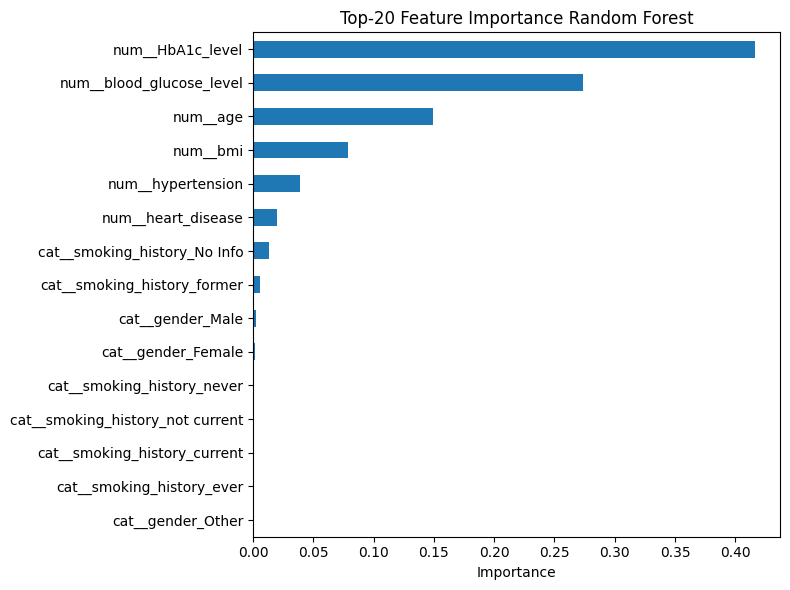

In [28]:
feature_names_rf = pipe_rf.named_steps["preprocess"].get_feature_names_out()
importances = pipe_rf.named_steps["model"].feature_importances_

imp_df = pd.DataFrame({"feature": feature_names_rf, "importance": importances})
imp_top = imp_df.sort_values("importance", ascending=False).head(20)

display(imp_top)

ax = imp_top.sort_values("importance").plot(kind="barh", x="feature", y="importance", legend=False, figsize=(8, 6))
ax.set_title("Top-20 Feature Importance Random Forest")
ax.set_xlabel("Importance")
ax.set_ylabel("")
plt.tight_layout()
plt.show()


### 11.3 (Opsional) SHAP untuk Random Forest

In [29]:
# SHAP bersifat opsional (sesuai proposal). Install jika perlu:
# pip install shap

try:
    import shap

    # Ambil data transform (set kecil agar cepat)
    X_test_small = X_test.sample(n=min(2000, len(X_test)), random_state=RANDOM_STATE)
    X_test_trans = pipe_rf.named_steps["preprocess"].transform(X_test_small)

    explainer = shap.TreeExplainer(pipe_rf.named_steps["model"])
    shap_values = explainer.shap_values(X_test_trans)

    shap.summary_plot(shap_values[1], X_test_trans, feature_names=feature_names_rf, show=False)
    plt.title("SHAP Summary Plot (Random Forest) - Kelas Positif")
    plt.show()

except ImportError as e:
    print("shap belum terpasang. Lewati SHAP.\n", str(e))
except Exception as e:
    print("Terjadi kendala saat menjalankan SHAP:", str(e))


shap belum terpasang. Lewati SHAP.
 No module named 'shap'


## 12) Simpan Model Terbaik untuk Deployment (joblib)

In [30]:
import joblib

joblib.dump(pipe_rf, "model.joblib", compress=3)



['model.joblib']